In [1]:
%pylab inline
import librosa 
from skimage import io
from matplotlib import pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa.display as display
print librosa.__version__
print tf.__version__
import tools as t
slim = tf.contrib.slim
from scipy.io import loadmat
import  numpy as np
from sklearn.cross_validation import train_test_split
import tensorflow.contrib.layers as lays

Populating the interactive namespace from numpy and matplotlib
0.5.1
1.3.0


# Generating mfcc's features from audio signals

In [2]:
def get_mat_data(path):
    dic1={}
    dirs=t.get_dirs(path, pattern="")
    for di in (sorted(dirs)[0:2]):
        files=t.getfiles(di+'/', '.wav')
        print di[-3::],',',
        for f in files:
            y,sr=librosa.load(f)
            mfcc=librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T # (Frames x 40)
            label=f[len(f)-8:-6]
            if label not in dic1:
                dic1[label]=[]
            dic1[label].append(mfcc)
            
    print " Classes:",len(dic1) # Some Sequence files are missing in data 
    
    dic2={}    
    for key in dic1:
        dic2[key]=np.vstack((dic1[key][0],dic1[key][1]))#,dic1[key][2],dic1[key][3],dic1[key][4],dic1[key][5],dic1[key][6],dic1[key][7],dic1[key][8],dic1[key][9]))    
    
    X=np.zeros((20000,80,40,20),dtype=np.float32) # NHWC
    Y=np.zeros((20000,1),dtype=np.int32)               # N
    rindx=0
    label=1
    for key in dic2:
        Frames=dic2[key][0:]
        N=dic2[key].shape[0]/80 
        nidx=0
        if N/20.0!=0:
            for i in range(N): 
                fmap=Frames[nidx:nidx+80,:]
                image=np.zeros((80,40,20),dtype=np.float32)
                for j in range(20):
                    image[:,:,j]=fmap
                X[rindx]=image
                Y[rindx]= label
                rindx+=1
                nidx+=80  
        label+=1
        
    X=X[0:rindx]
    Y=Y[0:rindx]
    
    return X,Y

In [23]:
path = "./Data/KING/NB"
X_King,Y_King = get_mat_data(path)

print X_King.shape
print Y_King.shape

S01 , S02 ,  Classes: 51
(2527, 80, 40, 20)
(2527, 1)


In [ ]:
np.save('X_KingNB',X_King)
np.save('Y_KingNB',Y_King)

In [5]:
X_King=np.load('./Speaker Verification/X_KingNB.npy')
Y_King=np.load('./Speaker Verification/Y_KingNB.npy')
print X_King.shape
print Y_King.shape

(12364, 80, 40, 20)
(12364, 1)


# Displaying Single mfcc features map

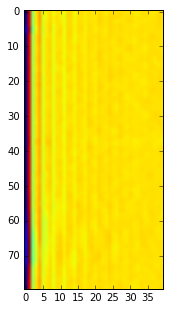

In [6]:
plt.figure(figsize=(5,5))
plt.imshow(X_King[50,:,:,0])

In [45]:
#mean = np.mean(X_King, axis=(0, 1, 2))
#std  = np.std (X_King, axis=(0, 1, 2))
#X_King[:, :, :, :] -= mean.reshape(1, 1, 1, 20)
#X_King[:, :, :, :] /=  std.reshape(1, 1, 1, 1)
X_train, X_test, y_train, y_test = train_test_split(X_King, Y_King,test_size=.20,random_state=1)
print  X_train.shape, y_train.shape 
print  X_test.shape , y_test.shape

(2021, 80, 40, 20) (2021, 1)
(506, 80, 40, 20) (506, 1)


In [48]:
# Store Fully Cenected layers weight & bias
weights = {
    'w1': tf.get_variable("W111", shape=[256,512],  initializer=tf.contrib.layers.xavier_initializer()),
    'w2': tf.get_variable("W222", shape=[512,1024], initializer=tf.contrib.layers.xavier_initializer()), 
    'outw': tf.get_variable("W333", shape=[1024,51],initializer=tf.contrib.layers.xavier_initializer())
           }
biases = {
    'b1': tf.Variable(tf.random_normal([512])),
    'b2': tf.Variable(tf.random_normal([1024])),
    'outb': tf.Variable(tf.random_normal([51]))
          }

In [49]:
def features_averages(images,true_labels):
    features_averages=[]
    feature_per_speaker={}
    for i in range(images.shape[0]):
        label=true_labels[i]
        if label not in  feature_per_speaker:
            feature_per_speaker[label]=[]
        feature_per_speaker[label].append(images)
    for key in feature_per_speaker:
        avg=np.sum(feature_per_speaker[key],axis=1)/len(feature_per_speaker[key])
        features_averages.append(avg)
    return np.array(features_averages)

# Cosine Similarity

In [50]:
def cosine_similarity(test,features_avg):
    similarity=[]
    for i in range(test.shape[0]):
        for j in range(features_avg.shape[0]):
                sim=np.cos(test[i],features_avg[j])
                similarity.append(sim)
    return np.array(similarity)                    

# Model Layers

In [33]:
global is_training
is_training=False
def Model(inputs): # (NxHxWx1)
    conv1=lays.conv2d(inputs,16,3,stride=1,padding='SAME',weights_initializer=tf.contrib.layers.xavier_initializer(),activation_fn=None)
    bnorm=lays.batch_norm(conv1,is_training=is_training,activation_fn=None)
    dropout=lays.dropout(bnorm,keep_prob=0.5,is_training=is_training)
    relu =tf.nn.relu(dropout)
    maxp1=lays.max_pool2d(relu,2,stride=2,padding='SAME')

    conv2=lays.conv2d(maxp1,32,3, stride=1,padding='SAME',weights_initializer=tf.contrib.layers.xavier_initializer(),activation_fn=None)
    bnorm=lays.batch_norm(conv2,is_training=is_training,activation_fn=tf.nn.relu)
    conv3=lays.conv2d(bnorm,32,3, stride=1,padding='SAME',weights_initializer=tf.contrib.layers.xavier_initializer(),activation_fn=None)
    bnorm=lays.batch_norm(conv3,is_training=is_training,activation_fn=tf.nn.relu)
    maxp2=lays.max_pool2d(bnorm,2,stride=2,padding='SAME')

    conv4=lays.conv2d(maxp2,64,3, stride=1,padding='SAME',weights_initializer=tf.contrib.layers.xavier_initializer(),activation_fn=None)
    bnorm=lays.batch_norm(conv4,is_training=is_training,activation_fn=tf.nn.relu)
    conv5=lays.conv2d(bnorm,64,3, stride=1,padding='SAME',weights_initializer=tf.contrib.layers.xavier_initializer(),activation_fn=None)
    bnorm=lays.batch_norm(conv5,is_training=is_training,activation_fn=tf.nn.relu)
    maxp3=lays.max_pool2d(bnorm,2,stride=2,padding='SAME')
    
    conv6=lays.conv2d(maxp3,128,3, stride=1,padding='SAME',weights_initializer=tf.contrib.layers.xavier_initializer(),activation_fn=None)
    bnorm=lays.batch_norm(conv6,is_training=is_training,activation_fn=tf.nn.relu)
    conv7=lays.conv2d(bnorm,128,3, stride=1,padding='SAME',weights_initializer=tf.contrib.layers.xavier_initializer(),activation_fn=None)
    bnorm=lays.batch_norm(conv7,is_training=is_training,activation_fn=tf.nn.relu)
    maxp4=lays.max_pool2d(bnorm,2,stride=2,padding='SAME')
   
    conv8=lays.conv2d(maxp4,256,[5,3],stride=1,padding='Valid',weights_initializer=tf.contrib.layers.xavier_initializer(),activation_fn=tf.nn.relu)
    
    conv=tf.reshape(conv8,[-1,256]) # 1x256 features
    
    features=conv
    
    fc1 = tf.nn.relu(tf.nn.bias_add(tf.matmul(conv, weights['w1']), biases['b1'])) # (10x256,256x512)+512   = 10x512
    fc2 = tf.nn.relu(tf.nn.bias_add(tf.matmul(fc1, weights['w2']), biases['b2'])) # (10x512,512x1024)+1024 = 10x1024
    fc3 = tf.nn.bias_add(tf.matmul(fc2, weights['outw']), biases['outb'])         # (10x1024,1024x51)+51   = 10x51
    
    logits=fc3
    
    return logits,features    # 10x51

In [35]:
batch_size = 10
training_epochs=10
total_batch = int(X_train.shape[0]/batch_size)
print 'total_batch : ',total_batch

total_batch :  176


In [39]:
X = tf.placeholder("float32", [None, 80,40,20])
Y = tf.placeholder("int32", [None, None])
label_onehot=tf.one_hot(tf.squeeze(Y), depth=51, axis=-1)

In [40]:
logits,features=Model(X)
loss=tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=label_onehot))
train_op=tf.train.AdamOptimizer().minimize(loss)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(label_onehot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [41]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    cf=[]
    for epoch in range(training_epochs):
        i=0
        for j in range(total_batch-1):
            batch_x, batch_y =X_train[i:i+batch_size],y_train[i:i+batch_size]
            
            _,loss_,acc_=sess.run([train_op,loss,accuracy],feed_dict={ X:batch_x, Y:batch_y })
            
            cf.append(loss_)
            acc=sess.run(accuracy,feed_dict={ X:X_test[i:i+batch_size], Y:y_test[i:i+batch_size] })
            if j%100==0 or j==0:
                print 'iteration:',j+1,' loss:',loss_, ' validation-acc:',acc
            i=i+batch_size
        print 'epoch:',epoch+1,' loss:',loss_
         
    print 'Optimization Finished!'
    
    loss_,accu_=sess.run([loss,accuracy],feed_dict={ X:X_test, Y:y_test })
    
    print ("test_loss : ", loss_)
    print ("test_accu : ", accu_)
print 'Expected Loss:',-np.log(1/51.0)    

iteration: 1  loss: 4.64572  acc: 0.1
iteration: 101  loss: 4.47729  acc: 0.0
epoch: 1  loss: 3.70977
iteration: 1  loss: 3.16617  acc: 0.0
iteration: 101  loss: 3.54044  acc: 0.0
epoch: 2  loss: 3.38694
iteration: 1  loss: 2.85841  acc: 0.0
iteration: 101  loss: 3.31466  acc: 0.0
epoch: 3  loss: 2.91554
iteration: 1  loss: 2.50778  acc: 0.1
iteration: 101  loss: 3.31247  acc: 0.0
epoch: 4  loss: 2.85203
iteration: 1  loss: 2.551  acc: 0.2
iteration: 101  loss: 3.22281  acc: 0.0
epoch: 5  loss: 3.06547
iteration: 1  loss: 2.62742  acc: 0.0
iteration: 101  loss: 3.76955  acc: 0.0
epoch: 6  loss: 2.9745
iteration: 1  loss: 2.40831  acc: 0.1
iteration: 101  loss: 3.11113  acc: 0.1
epoch: 7  loss: 7.76651
iteration: 1  loss: 8.53561  acc: 0.1
iteration: 101  loss: 3.37798  acc: 0.0
epoch: 8  loss: 2.93172
iteration: 1  loss: 2.45087  acc: 0.1
iteration: 101  loss: 3.58573  acc: 0.1
epoch: 9  loss: 12.559
iteration: 1  loss: 14.5701  acc: 0.0
iteration: 101  loss: 3.66508  acc: 0.0
epoch: 1

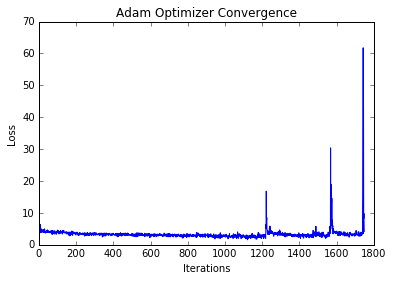

In [42]:
plt.plot(cf,'-')
plt.title('Adam Optimizer Convergence')
plt.xlabel('Iterations')
plt.ylabel('Loss')